# [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch)

In [41]:
# !pip install efficientnet_pytorch

### Classes = angry[0] , Happy[1], Neutral[2]


In [21]:
import glob
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader , random_split
from torchsummary import summary
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
import tensorflow as tf
import keras
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score


In [ ]:
class FerTrain(Dataset):
    def __init__(self): # add additional parameters needed to load the dataset e.g dataset path
        self.train_images  = np.load('train_images.npy')
        self.train_labels = np.load('train_labels.npy')
        len(self.train_images)

    def __len__(self):
        return len(self.train_images)

    def __getitem__(self, idx):
        img = self.train_images[idx,:]
        img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_LINEAR)
        img= img.reshape(256,256,1)
        img=img.astype(np.float32)
        img=img.T
        img_tensor = torch.from_numpy(img)
        label= torch.from_numpy(self.train_labels[idx]).to(torch.float32)

        return img_tensor, label

In [3]:
class FerTest(Dataset):
  def __init__(self): # add additional parameters needed to load the dataset e.g dataset path
        self.test_images  = np.load('test_images.npy')
        self.test_labels = np.load('test_labels.npy')

  def __len__(self):
        return self.test_images.shape[0]

  def __getitem__(self, idx):
      # your code here
      img = self.test_images[idx]
      img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_LANCZOS4)
      img= img.reshape(256,256,1)
      img=img.astype(np.float32)
      img=img.T
      img_tensor = torch.from_numpy(img)

      label= torch.from_numpy(self.test_labels[idx]).to(torch.float32)

      return img_tensor, label

In [4]:
class FerDrivingTest(Dataset):
  def __init__(self): # add additional parameters needed to load the dataset e.g dataset path
        self.test_images  = np.load('driving_data_test_images.npy')
        self.test_labels = np.load('driving_data_test_labels.npy')
        print(self.test_images.shape)

  def __len__(self):
        return self.test_images.shape[0]

  def __getitem__(self, idx):
      # your code here
      img = self.test_images[idx]
    #   img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_LANCZOS4)
    #   img= img.reshape(256,256,1)
      img=img.astype(np.float32)
      img=img.T
      img_tensor = torch.from_numpy(img)

      label= torch.from_numpy(self.test_labels[idx]).to(torch.float32)

      return img_tensor, label

In [66]:
fer = FerDrivingTest()
fer.__getitem__(100)

(938, 256, 256, 1)


(tensor([[[0.1184, 0.2074, 0.3012,  ..., 0.2082, 0.2264, 0.2138],
          [0.0892, 0.0779, 0.0938,  ..., 0.2463, 0.2246, 0.2585],
          [0.3842, 0.2506, 0.1719,  ..., 0.2280, 0.2291, 0.2356],
          ...,
          [0.2645, 0.2651, 0.2621,  ..., 0.1793, 0.1739, 0.1710],
          [0.2410, 0.2379, 0.2311,  ..., 0.1608, 0.1615, 0.1735],
          [0.2156, 0.2139, 0.2070,  ..., 0.1363, 0.1527, 0.1736]]]),
 tensor([0., 0., 1.]))

# EfficientNet

In [4]:
model = EfficientNet.from_pretrained('efficientnet-b0')

# Adjust the first convolutional layer to accept 1-channel input
# EfficientNet's first conv layer is `_conv_stem`
# Create a new conv layer with 1 input channel, same output channels, kernel size, etc.
conv_stem = model._conv_stem
new_conv_stem = nn.Conv2d(
    in_channels=1,  # Change to 1 channel for grayscale
    out_channels=conv_stem.out_channels,
    kernel_size=conv_stem.kernel_size,
    stride=conv_stem.stride,
    padding=conv_stem.padding,
    bias=conv_stem.bias is not None,
    groups=conv_stem.groups,
    dilation=conv_stem.dilation,
)
# Copy weights from the original conv layer (average them for the grayscale case)
with torch.no_grad():
    new_conv_stem.weight[:, 0, :, :] = conv_stem.weight.mean(dim=1)
model._conv_stem = new_conv_stem
num_features = model._fc.in_features
model._fc = nn.Linear(num_features, 3)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, (1, 256, 256))

Loaded pretrained weights for efficientnet-b0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 127, 127]             288
       BatchNorm2d-2         [-1, 32, 127, 127]              64
MemoryEfficientSwish-3         [-1, 32, 127, 127]               0
         ZeroPad2d-4         [-1, 32, 129, 129]               0
Conv2dStaticSamePadding-5         [-1, 32, 127, 127]             288
       BatchNorm2d-6         [-1, 32, 127, 127]              64
MemoryEfficientSwish-7         [-1, 32, 127, 127]               0
          Identity-8             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-9              [-1, 8, 1, 1]             264
MemoryEfficientSwish-10              [-1, 8, 1, 1]               0
         Identity-11              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-12             [-1, 32, 1, 1]             288
         Identity-13         [-1, 

## Preparing Training & Validation Dataset

In [25]:
train_dataset = FerTrain()
split_size_train = int(len(train_dataset) * 0.75)
split_size_val = len(train_dataset) - split_size_train
train, valid = random_split(train_dataset, lengths=[split_size_train, split_size_val])
batch_size = 16
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=True)


for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

Image batch shape: torch.Size([16, 1, 256, 256])
Label batch shape: torch.Size([16, 3])


In [5]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

# Training of EfficientNet

In [ ]:
# Maybe we could change here to fix the shape of the graphs below
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0.0
epochs = 50

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()
    running_loss = 0.0
    train_accuracy = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
        images = images.to(device)
        labels = labels.argmax(dim=1).to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, labels)

    avg_train_loss = running_loss / len(train_loader)
    avg_train_accuracy = train_accuracy / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.argmax(dim=1).to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            val_accuracy += calculate_accuracy(outputs, labels)

    avg_val_loss = val_loss / len(valid_loader)
    avg_val_accuracy = val_accuracy / len(valid_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    if avg_val_accuracy > best_val_acc:
        best_val_acc = avg_val_accuracy
        torch.save(model.state_dict(), 'EfficientNet_best_model.pt')

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Acc: {avg_val_accuracy:.4f}")


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.1204, Train Acc: 0.9573, Validation Loss: 1.0797, Validation Acc: 0.7758


Epoch 2/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.0989, Train Acc: 0.9649, Validation Loss: 0.8023, Validation Acc: 0.7568


Epoch 3/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.0950, Train Acc: 0.9655, Validation Loss: 0.8360, Validation Acc: 0.7946


Epoch 4/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.0895, Train Acc: 0.9696, Validation Loss: 1.0061, Validation Acc: 0.7798


Epoch 5/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.0729, Train Acc: 0.9736, Validation Loss: 1.0013, Validation Acc: 0.7783


Epoch 6/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.0769, Train Acc: 0.9724, Validation Loss: 0.9390, Validation Acc: 0.7859


Epoch 7/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.0646, Train Acc: 0.9772, Validation Loss: 1.0329, Validation Acc: 0.7939


Epoch 8/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.0667, Train Acc: 0.9769, Validation Loss: 0.9626, Validation Acc: 0.7950


Epoch 9/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.0654, Train Acc: 0.9756, Validation Loss: 1.0837, Validation Acc: 0.7894


Epoch 10/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.0595, Train Acc: 0.9792, Validation Loss: 1.0387, Validation Acc: 0.8013


Epoch 11/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.0559, Train Acc: 0.9805, Validation Loss: 0.9471, Validation Acc: 0.7983


Epoch 12/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.0572, Train Acc: 0.9792, Validation Loss: 1.1100, Validation Acc: 0.7899


Epoch 13/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.0481, Train Acc: 0.9838, Validation Loss: 1.3991, Validation Acc: 0.7792


Epoch 14/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.0584, Train Acc: 0.9801, Validation Loss: 1.0092, Validation Acc: 0.7923


Epoch 15/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.0454, Train Acc: 0.9839, Validation Loss: 0.9106, Validation Acc: 0.7843


Epoch 16/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.0490, Train Acc: 0.9825, Validation Loss: 1.0666, Validation Acc: 0.7893


Epoch 17/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.0412, Train Acc: 0.9859, Validation Loss: 1.0988, Validation Acc: 0.7890


Epoch 18/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.0509, Train Acc: 0.9826, Validation Loss: 1.0554, Validation Acc: 0.7886


Epoch 19/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.0473, Train Acc: 0.9832, Validation Loss: 1.1055, Validation Acc: 0.7851


Epoch 20/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.0485, Train Acc: 0.9834, Validation Loss: 0.9526, Validation Acc: 0.7890


Epoch 21/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.0379, Train Acc: 0.9872, Validation Loss: 1.1308, Validation Acc: 0.7767


Epoch 22/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.0432, Train Acc: 0.9846, Validation Loss: 1.0550, Validation Acc: 0.7865


Epoch 23/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0364, Train Acc: 0.9863, Validation Loss: 1.1467, Validation Acc: 0.7845


Epoch 24/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.0408, Train Acc: 0.9846, Validation Loss: 1.0671, Validation Acc: 0.7927


Epoch 25/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.0358, Train Acc: 0.9881, Validation Loss: 1.0823, Validation Acc: 0.7959


Epoch 26/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.0338, Train Acc: 0.9875, Validation Loss: 1.2536, Validation Acc: 0.7774


Epoch 27/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0355, Train Acc: 0.9871, Validation Loss: 1.1599, Validation Acc: 0.7942


Epoch 28/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0392, Train Acc: 0.9867, Validation Loss: 1.0639, Validation Acc: 0.7945


Epoch 29/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0264, Train Acc: 0.9903, Validation Loss: 1.4109, Validation Acc: 0.7861


Epoch 30/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0382, Train Acc: 0.9878, Validation Loss: 1.0584, Validation Acc: 0.8003


Epoch 31/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0404, Train Acc: 0.9856, Validation Loss: 1.0349, Validation Acc: 0.7978


Epoch 32/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0247, Train Acc: 0.9916, Validation Loss: 1.1306, Validation Acc: 0.8029


Epoch 33/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0344, Train Acc: 0.9881, Validation Loss: 1.1720, Validation Acc: 0.7902


Epoch 34/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0362, Train Acc: 0.9876, Validation Loss: 1.1527, Validation Acc: 0.8029


Epoch 35/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0316, Train Acc: 0.9895, Validation Loss: 1.2174, Validation Acc: 0.8018


Epoch 36/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0219, Train Acc: 0.9924, Validation Loss: 1.1085, Validation Acc: 0.7929


Epoch 37/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0311, Train Acc: 0.9895, Validation Loss: 1.2566, Validation Acc: 0.7857


Epoch 38/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0332, Train Acc: 0.9881, Validation Loss: 1.1897, Validation Acc: 0.7968


Epoch 39/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0228, Train Acc: 0.9922, Validation Loss: 1.4365, Validation Acc: 0.7880


Epoch 40/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0286, Train Acc: 0.9895, Validation Loss: 1.3577, Validation Acc: 0.7926


Epoch 41/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0386, Train Acc: 0.9862, Validation Loss: 1.0719, Validation Acc: 0.7934


Epoch 42/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0190, Train Acc: 0.9932, Validation Loss: 1.1692, Validation Acc: 0.7988


Epoch 43/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0298, Train Acc: 0.9898, Validation Loss: 1.1563, Validation Acc: 0.7974


Epoch 44/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0249, Train Acc: 0.9918, Validation Loss: 1.2581, Validation Acc: 0.8005


Epoch 45/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0274, Train Acc: 0.9905, Validation Loss: 1.2094, Validation Acc: 0.7876


Epoch 46/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0257, Train Acc: 0.9918, Validation Loss: 1.0686, Validation Acc: 0.7967


Epoch 47/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0241, Train Acc: 0.9911, Validation Loss: 1.3844, Validation Acc: 0.7810


Epoch 48/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0329, Train Acc: 0.9882, Validation Loss: 1.1316, Validation Acc: 0.7997


Epoch 49/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0243, Train Acc: 0.9914, Validation Loss: 1.3106, Validation Acc: 0.7948


Epoch 50/50 - Training:   0%|          | 0/759 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0181, Train Acc: 0.9939, Validation Loss: 1.2188, Validation Acc: 0.8019


## Graphs (Training and Validation)

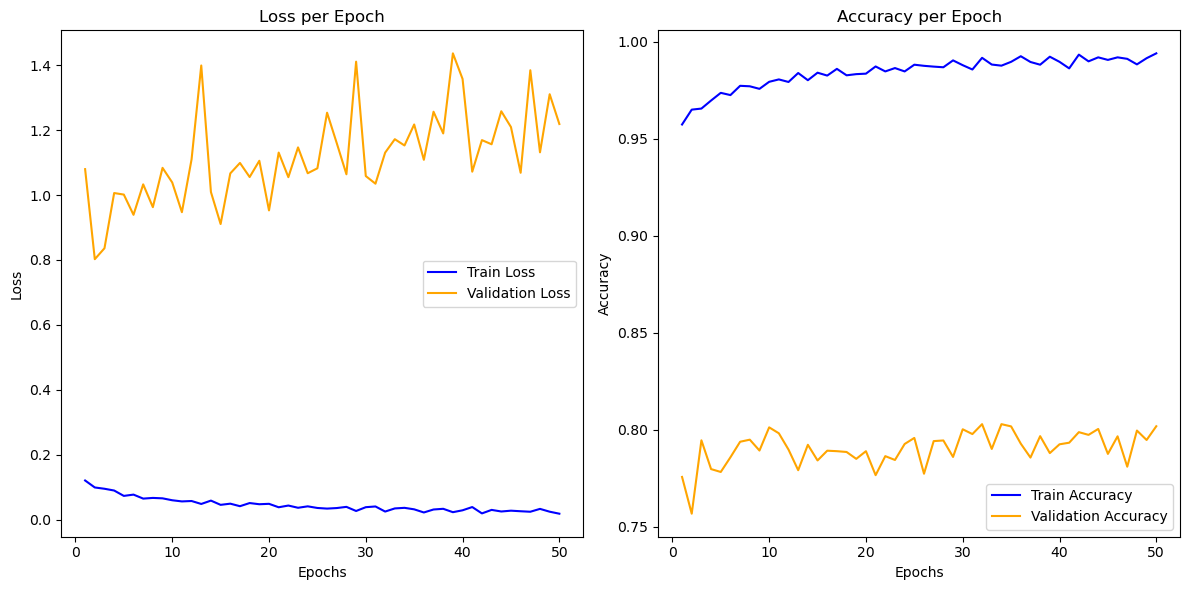

In [30]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='orange')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Total Accuracy: 79.4199 %
Classification Report:
              precision    recall  f1-score   support

       angry       0.73      0.69      0.71       958
       happy       0.93      0.82      0.87      1774
     neutral       0.69      0.83      0.75      1233

    accuracy                           0.79      3965
   macro avg       0.78      0.78      0.78      3965
weighted avg       0.81      0.79      0.80      3965



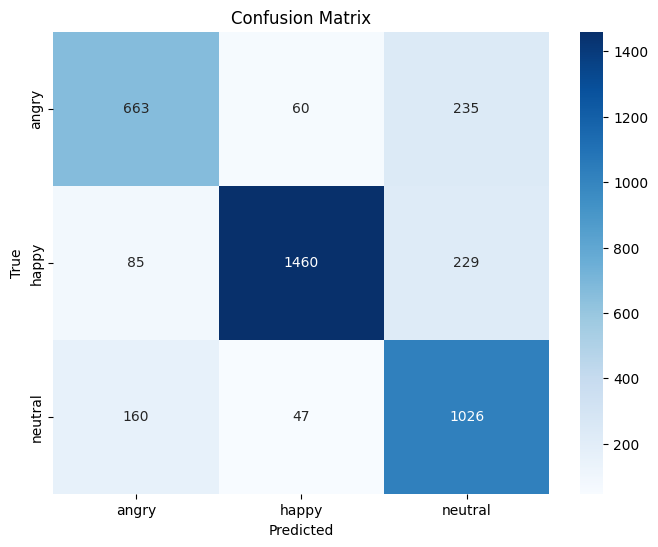

In [ ]:
model_test = model
model_test.load_state_dict(torch.load('EfficientNet_best_model.pt', weights_only=True))
model_test.to(device)
class_names = ['angry', 'happy', 'neutral']

test_dataset = FerTest()
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

all_labels = []
all_preds = []
correct_predictions = 0
total_samples = 0
model_test.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.argmax(dim=1).to(device)
        outputs = model_test(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

total_accuracy = (correct_predictions / total_samples)*100
print(f"Total Accuracy: {total_accuracy:.4f} %")

report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [5]:
model = EfficientNet.from_pretrained('efficientnet-b0')

# Adjust the first convolutional layer to accept 1-channel input
# EfficientNet's first conv layer is `_conv_stem`
# Create a new conv layer with 1 input channel, same output channels, kernel size, etc.
conv_stem = model._conv_stem
new_conv_stem = nn.Conv2d(
    in_channels=1,  # Change to 1 channel for grayscale
    out_channels=conv_stem.out_channels,
    kernel_size=conv_stem.kernel_size,
    stride=conv_stem.stride,
    padding=conv_stem.padding,
    bias=conv_stem.bias is not None,
    groups=conv_stem.groups,
    dilation=conv_stem.dilation,
)
# Copy weights from the original conv layer (average them for the grayscale case)
with torch.no_grad():
    new_conv_stem.weight[:, 0, :, :] = conv_stem.weight.mean(dim=1)
model._conv_stem = new_conv_stem
num_features = model._fc.in_features
model._fc = nn.Linear(num_features, 3)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, (1, 256, 256))

Loaded pretrained weights for efficientnet-b0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 127, 127]             288
       BatchNorm2d-2         [-1, 32, 127, 127]              64
MemoryEfficientSwish-3         [-1, 32, 127, 127]               0
         ZeroPad2d-4         [-1, 32, 129, 129]               0
Conv2dStaticSamePadding-5         [-1, 32, 127, 127]             288
       BatchNorm2d-6         [-1, 32, 127, 127]              64
MemoryEfficientSwish-7         [-1, 32, 127, 127]               0
          Identity-8             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-9              [-1, 8, 1, 1]             264
MemoryEfficientSwish-10              [-1, 8, 1, 1]               0
         Identity-11              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-12             [-1, 32, 1, 1]             288
         Identity-13         [-1, 

Total Accuracy: 33.3333 %
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       396
       happy       0.00      0.00      0.00       396
     neutral       0.33      1.00      0.50       396

    accuracy                           0.33      1188
   macro avg       0.11      0.33      0.17      1188
weighted avg       0.11      0.33      0.17      1188



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


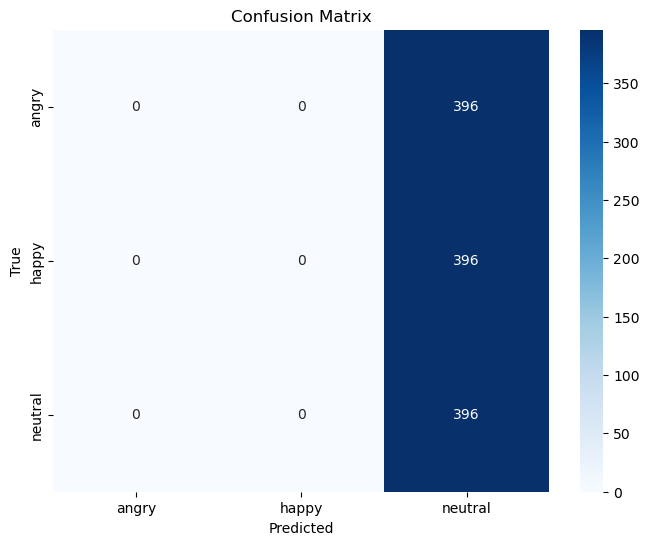

In [6]:
model_driving_test = model
model_driving_test.load_state_dict(torch.load('EfficientNet_best_model.pt', weights_only=True))
model_driving_test.to(device)
class_names = ['angry', 'happy', 'neutral']

test_dataset = FerDrivingTest()
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

all_labels = []
all_preds = []
correct_predictions = 0
total_samples = 0
model_driving_test.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.argmax(dim=1).to(device)
        outputs = model_driving_test(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

total_accuracy = (correct_predictions / total_samples)*100
print(f"Total Accuracy: {total_accuracy:.4f} %")

report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Fine Tuning

In [6]:
class DrivingFineTune(Dataset):
    def __init__(self, samples=100): # add additional parameters needed to load the dataset e.g dataset path
        self.train_images  = np.load('train_images_fine_tune.npy')
        random_samples = np.random.randint(self.train_images.shape[0], size=samples)
        self.train_images = self.train_images[random_samples, :]
        self.train_labels = np.load('train_labels_fine_tune.npy')
        self.train_labels = self.train_labels[random_samples,:]
        len(self.train_images.shape)

    def __len__(self):
        return len(self.train_images)

    def __getitem__(self, idx):
        img = self.train_images[idx]
        # img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_LINEAR)
        # img= img.reshape(256,256,1)
        img=img.astype(np.float32)
        img=img.T
        img_tensor = torch.from_numpy(img)

        label= torch.from_numpy(self.train_labels[idx]).to(torch.float32)

        return img_tensor, label

In [74]:
# A = np.load('train_images_fine_tune.npy')
# np.random.randint(A.shape[0], size=100)

In [7]:
t = DrivingFineTune()
print(t.__getitem__(0)[1])
print(t.__getitem__(30)[1])
print(t.__getitem__(99)[1])


tensor([1., 0., 0.])
tensor([0., 0., 1.])
tensor([0., 1., 0.])


In [8]:
model = EfficientNet.from_pretrained('efficientnet-b0')

# Adjust the first convolutional layer to accept 1-channel input
# EfficientNet's first conv layer is `_conv_stem`
# Create a new conv layer with 1 input channel, same output channels, kernel size, etc.
conv_stem = model._conv_stem
new_conv_stem = nn.Conv2d(
    in_channels=1,  # Change to 1 channel for grayscale
    out_channels=conv_stem.out_channels,
    kernel_size=conv_stem.kernel_size,
    stride=conv_stem.stride,
    padding=conv_stem.padding,
    bias=conv_stem.bias is not None,
    groups=conv_stem.groups,
    dilation=conv_stem.dilation,
)
# Copy weights from the original conv layer (average them for the grayscale case)
with torch.no_grad():
    new_conv_stem.weight[:, 0, :, :] = conv_stem.weight.mean(dim=1)
model._conv_stem = new_conv_stem
num_features = model._fc.in_features
model._fc = nn.Linear(num_features, 3)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, (1, 256, 256))

Loaded pretrained weights for efficientnet-b0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 127, 127]             288
       BatchNorm2d-2         [-1, 32, 127, 127]              64
MemoryEfficientSwish-3         [-1, 32, 127, 127]               0
         ZeroPad2d-4         [-1, 32, 129, 129]               0
Conv2dStaticSamePadding-5         [-1, 32, 127, 127]             288
       BatchNorm2d-6         [-1, 32, 127, 127]              64
MemoryEfficientSwish-7         [-1, 32, 127, 127]               0
          Identity-8             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-9              [-1, 8, 1, 1]             264
MemoryEfficientSwish-10              [-1, 8, 1, 1]               0
         Identity-11              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-12             [-1, 32, 1, 1]             288
         Identity-13         [-1, 

In [9]:
# split_size_train = int(len(train_fine_tune_dataset) * 0.75)
# split_size_val = len(train_fine_tune_dataset) - split_size_train
# train, valid = random_split(train_fine_tune_dataset, lengths=[split_size_train, split_size_val])
train_fine_tune_dataset = DrivingFineTune()
batch_size = 16
train_loader = DataLoader(train_fine_tune_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=True)

for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

Image batch shape: torch.Size([16, 1, 256, 256])
Label batch shape: torch.Size([16, 3])


In [15]:
# Maybe we could change here to fix the shape of the graphs below
best_val_acc = 0.0
epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for samples in range(100,801, 100):
    model.load_state_dict(torch.load('EfficientNet_best_model.pt', weights_only=True))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_fine_tune_dataset = DrivingFineTune(samples=samples)
    batch_size = 16
    train_loader = DataLoader(train_fine_tune_dataset, batch_size=batch_size, shuffle=True)

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        running_loss = 0.0
        train_accuracy = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.argmax(dim=1).to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_accuracy += calculate_accuracy(outputs, labels)

        avg_train_loss = running_loss / len(train_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
    torch.save(model.state_dict(), f'Effecient Net Weights\\run2\\EfficientNet_{samples}.pt')
    
    print(f"Samples: {samples} Epoch [{epoch+1}/{epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f} ")



Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Samples: 100 Epoch [50/50], Train Loss: 0.0008, Train Acc: 1.0000 


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Samples: 200 Epoch [50/50], Train Loss: 0.0022, Train Acc: 1.0000 


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Samples: 300 Epoch [50/50], Train Loss: 0.0585, Train Acc: 0.9901 


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Samples: 400 Epoch [50/50], Train Loss: 0.0044, Train Acc: 1.0000 


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Samples: 500 Epoch [50/50], Train Loss: 0.0017, Train Acc: 1.0000 


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Samples: 600 Epoch [50/50], Train Loss: 0.0033, Train Acc: 1.0000 


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Samples: 700 Epoch [50/50], Train Loss: 0.0011, Train Acc: 1.0000 


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Samples: 800 Epoch [50/50], Train Loss: 0.0126, Train Acc: 0.9975 


In [33]:
from sklearn.metrics import f1_score

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

model_driving_test = model

for models in glob.glob('Effecient Net Weights\\run2\\*.pt'):
    num_samples = models.split('_')[-1][:3]

    model_driving_test.load_state_dict(torch.load(models, weights_only=True))
    model_driving_test.to(device)
    class_names = ['angry', 'happy', 'neutral']
    test_dataset = FerDrivingTest()
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    all_labels = []
    all_preds = []
    correct_predictions = 0
    total_samples = 0
    model_driving_test.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.argmax(dim=1).to(device)  # Convert one-hot labels to class indices
            outputs = model_driving_test(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class indices
            all_labels.extend(labels.cpu().numpy())  # Collect true labels
            all_preds.extend(preds.cpu().numpy())    # Collect predictions
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate Accuracy
    total_accuracy = (correct_predictions / total_samples) * 100

    # Calculate F1 Score
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Use weighted average for label imbalance

    print(f"Training Samples: {num_samples}")
    print(f"Total Accuracy: {total_accuracy:.4f} %")
    print(f"F1 Score: {f1:.4f}")

    # report = classification_report(all_labels, all_preds, target_names=class_names)
    # print("Classification Report:")
    # print(report)

    # conf_matrix = confusion_matrix(all_labels, all_preds)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    # plt.title('Confusion Matrix')
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.show()


(938, 256, 256, 1)
Training Samples: 100
Total Accuracy: 37.6333 %
F1 Score: 0.3736
(938, 256, 256, 1)
Training Samples: 200
Total Accuracy: 51.7058 %
F1 Score: 0.5177
(938, 256, 256, 1)
Training Samples: 300
Total Accuracy: 56.3966 %
F1 Score: 0.5589
(938, 256, 256, 1)
Training Samples: 400
Total Accuracy: 61.5139 %
F1 Score: 0.6173
(938, 256, 256, 1)
Training Samples: 500
Total Accuracy: 66.7377 %
F1 Score: 0.6690
(938, 256, 256, 1)
Training Samples: 600
Total Accuracy: 74.4136 %
F1 Score: 0.7411
(938, 256, 256, 1)
Training Samples: 700
Total Accuracy: 78.7846 %
F1 Score: 0.7873
(938, 256, 256, 1)
Training Samples: 800
Total Accuracy: 82.4094 %
F1 Score: 0.8237


Total Accuracy: 72.1564 %
Classification Report:
              precision    recall  f1-score   support

       angry       0.63      0.65      0.64       958
       happy       0.76      0.88      0.82      1774
     neutral       0.74      0.55      0.63      1233

    accuracy                           0.72      3965
   macro avg       0.71      0.69      0.69      3965
weighted avg       0.72      0.72      0.71      3965



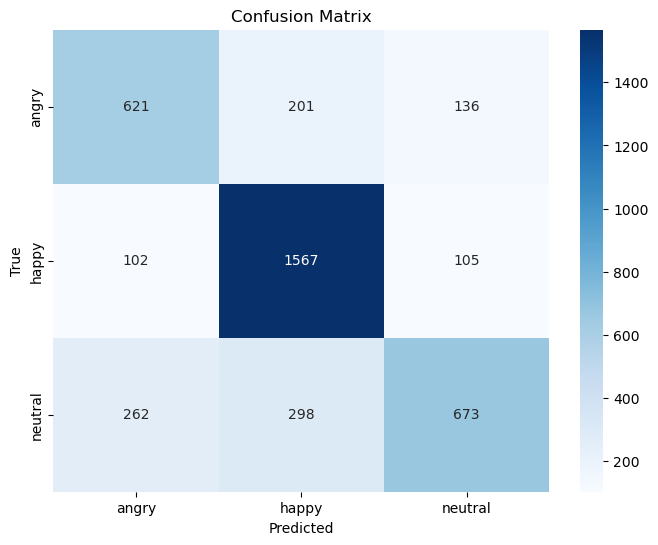

In [20]:
model_test = model
model_test.load_state_dict(torch.load('Effecient Net Weights\\run2\\EfficientNet_100.pt', weights_only=True))
model_test.to(device)
class_names = ['angry', 'happy', 'neutral']

test_dataset = FerTest()
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

all_labels = []
all_preds = []
correct_predictions = 0
total_samples = 0
model_test.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.argmax(dim=1).to(device)
        outputs = model_test(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

total_accuracy = (correct_predictions / total_samples)*100
print(f"Total Accuracy: {total_accuracy:.4f} %")

report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
